Welcome to our code! Please run through each block and you can visualize the results of our technique.

functions.py contains the 3 functions that are used for our technique
miccai_sample.py is a downsampled FOV from one channel of a spatial transcriptomic experiment

this should be run in python3

In cell 1, I hardcoded the versions for the 4 packages, but this script will work the current versions of each of these packages as well.

In [ ]:
## RUN FOR DEPENDENCIES
import sys

!{sys.executable} -m pip install numpy==1.19.5
!{sys.executable} -m pip install matplotlib==3.3.2
!{sys.executable} -m pip install scipy==1.5.2
!{sys.executable} -m pip install scikit-image==0.17.2

Here we set some parameters that are used to correct the downsampled image

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt  
import os
from math import ceil, floor
from scipy.ndimage import gaussian_filter
from skimage.transform import resize, rescale
from functions import data_loader, vignette_correction, apply_vignette_correction

#Full Res Version
myPath = os.getcwd() # folder containing 
downsample_factor = 50 # just to speed up vignette estimation (reduces X and Y resolutions)
downslice_factor = 2 # just to speed up vignette estimation (use only a random subset of slices)
numiter = 5
bins = 10 # never greater than x_int/ds_factor

#load in the data!
x_int, y_int, z_int, num_chans, files, positions, dataVolume = data_loader(myPath, downsample_factor, downslice_factor)

# calculate vignette correction
# you can change a couple parameters here dataVolume, numbins = 200, templatetype = 'middle_slice'
# I recommend keeping them at default for now, but if you feel the num bins isn't adequate, you can increase the numbins
# as well changing the downsample and downslice factors
Sh = {}
Sv = {}
Dh = {}
Dv = {}
corr_vfield = {}
vfield = {}
for i in range(num_chans): 
    _,Sh[i], Sv[i], Dh[i], Dv[i], corr_vfield[i], vfield[i] = vignette_correction(dataVolume[:,:,:,i],numbins = bins)  

# rescales the coefficients and intercepts from the solved lin alg for histogram normalization to be the correct dimensions.
nSh = {}
nSv = {}
nDh = {}
nDv = {}
for i in range(num_chans):
    nSh[i] = rescale(Sh[i], (1,x_int/len(Sh[i][0])))    
    nSv[i] = rescale(Sv[i], (1,y_int/len(Sv[i][0])))
    nDh[i] = rescale(Dh[i], (1,x_int/len(Dh[i][0])))
    nDv[i] = rescale(Dv[i], (1,y_int/len(Dv[i][0])))

corr_stack, raw_stack = apply_vignette_correction(files[0],x_int,y_int,z_int,nSh,nDh,nSv,nDv)


Now we visualize the raw and corrected images to see how our technique did.

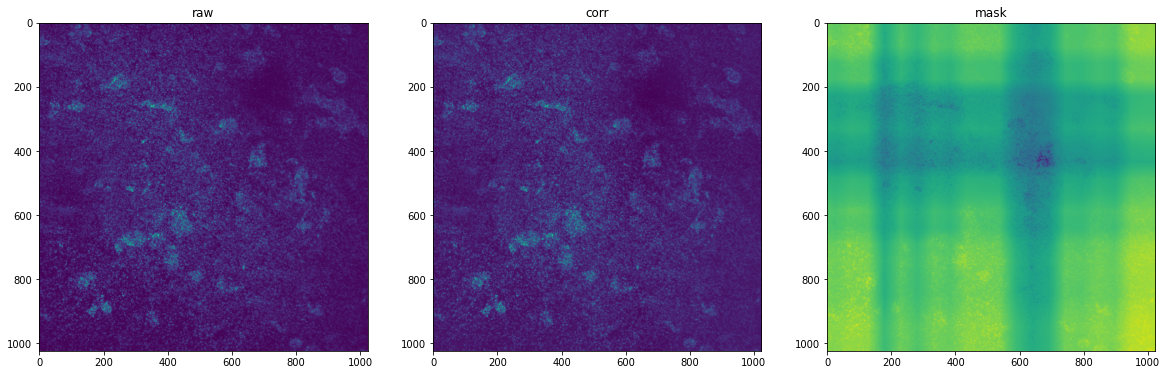

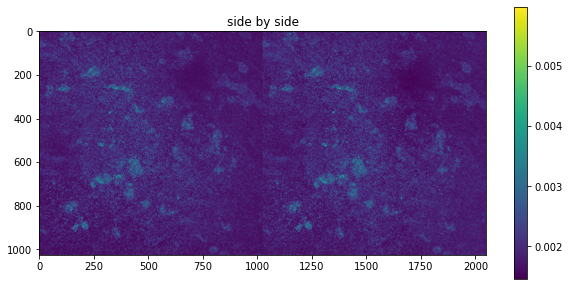

In [6]:
raw_stack_proj = np.max(np.max(raw_stack,axis=0),axis=0)
corr_stack_proj = np.max(np.max(corr_stack, axis=0),axis=0)
mask = corr_stack_proj - raw_stack_proj
f1, ax1 = plt.subplots(1,3,figsize=(20,60))
ax1[0].imshow(raw_stack_proj)
ax1[0].set_title('raw')
ax1[1].imshow(corr_stack_proj)
ax1[1].set_title('corr')
ax1[2].imshow(mask)
ax1[2].set_title('mask')
plt.show()

f2 = plt.figure(figsize=(10,5))
combined = np.concatenate((raw_stack_proj,corr_stack_proj),axis=1)
plt.imshow(combined)
plt.colorbar()
plt.title('side by side')
plt.show()

Here, we do a qualitative check for the flatness of each image

In [ ]:
s = raw_stack_proj.shape[0]/5
vfield = gaussian_filter(raw_stack_proj, sigma=s,mode = 'nearest',truncate=2.0)
vfield_corrected = gaussian_filter(corr_stack_proj, sigma=s,mode = 'nearest',truncate=2.0)
f3, ax3 = plt.subplots(1,2,figsize=(10,30))
ax3[0].imshow(vfield)
ax3[0].set_title('raw')
ax3[1].imshow(vfield_corrected)
ax3[1].set_title('corr')
plt.show()

f4 = plt.figure(figsize=(10,5))
combined_vfield = np.concatenate((vfield,vfield_corrected),axis=1)
plt.imshow(combined_vfield)
plt.colorbar()
plt.title('side by side')
plt.show()

Finally we examine the horizontal and vertical projections of the maximum intensity projection

In [ ]:
h_proj_raw = np.max(raw_stack_proj,axis=1)
v_proj_raw = np.max(raw_stack_proj,axis=0)
h_proj_corr = np.max(corr_stack_proj,axis=1)
v_proj_corr = np.max(corr_stack_proj,axis=0)

f5, ax5 = plt.subplots(2,figsize=(10,5))
ax5[0].plot(h_proj_raw,'o',label='raw')
ax5[0].plot(h_proj_corr,'o',label='corr')
ax5[0].set_title('horizontal maximum intensity')
ax5[0].legend()
ax5[1].plot(v_proj_raw,'o',label='raw')
ax5[1].plot(v_proj_corr,'o',label='corr')
ax5[1].set_title('vertical maximum intensity')
ax5[1].legend()
